In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_doh, blob_log

import torch
from torch import nn
from torchvision import transforms as pth_transforms

from PIL import Image

import vision_transformer as vits

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# Load Dataset

In [24]:
df = pd.read_csv('jacks5to8.csv', index_col=0)
df.time = pd.to_datetime(df.time)
df = df
df

,filename,time
0,./data/images/2021-07-12 07:35:03-07:00.png,2021-07-12 07:35:03-07:00
1,./data/images/2021-07-12 07:36:03-07:00.png,2021-07-12 07:36:03-07:00
2,./data/images/2021-07-12 07:37:03-07:00.png,2021-07-12 07:37:03-07:00
3,./data/images/2021-07-12 07:38:03-07:00.png,2021-07-12 07:38:03-07:00
4,./data/images/2021-07-12 07:39:03-07:00.png,2021-07-12 07:39:03-07:00
...,...,...
193,./data/images/2021-07-12 07:00:57-07:00.png,2021-07-12 07:00:57-07:00
194,./data/images/2021-07-12 07:01:57-07:00.png,2021-07-12 07:01:57-07:00
195,./data/images/2021-07-12 07:02:57-07:00.png,2021-07-12 07:02:57-07:00
196,./data/images/2021-07-12 07:03:57-07:00.png,2021-07-12 07:03:57-07:00


## Load model

In [4]:
arch = 'vit_small'
patch_size = 8
pretrained_weights = 'vit_small'
checkpoint_key = None
image_path = './data/images/'

# image_size = (592, 1184)
output_dir = '.'
threshold = None

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(pretrained_weights):
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    if checkpoint_key is not None and checkpoint_key in state_dict:
        print(f"Take key {checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))
else:
    print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
    url = None
    if arch == "vit_small" and patch_size == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
    elif arch == "vit_small" and patch_size == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
    elif arch == "vit_base" and patch_size == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
    elif arch == "vit_base" and patch_size == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    if url is not None:
        print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        model.load_state_dict(state_dict, strict=True)
    else:
        print("There is no reference weights available for this model => We use random weights.")

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /home/lathomas5/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth


In [6]:
def load_image(file, image_size = (592, 1184)):
    '''loads picture and applies torch transforms'''
    img = Image.open(file)
    img = img.convert('RGB')
    
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)
    
    return img

In [7]:
def patch_image(img, patch_size):
    '''Reshapes image to be divisible by the patch size'''
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    
    return img, w_featmap, h_featmap

In [21]:
def mask_image(img, patch_size):
    '''Passes image through model and returns attention mask'''
    img, w_featmap, h_featmap = patch_image(img, patch_size)
    attentions = model.get_last_selfattention(img.to(device))
    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    heatmap = attentions[0, :, 0, 1:].reshape(nh, -1)
    heatmap = heatmap.reshape(nh, w_featmap, h_featmap)
    
    # interpolate attention mask back to original image size
    heatmap = nn.functional.interpolate(heatmap.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    
    return heatmap.sum(0).astype('double')

In [22]:
def get_blobs(heatimg):
    '''
    predicts the number of surfers as the number of 
    blobs found in the attention mask of an image
    '''
    blobs = blob_doh(heatimg*256, threshold=0.05, min_sigma = 10, max_sigma=50)
    
    return blobs

In [23]:
def predict(row, patch_size=8):
    img = load_image(row['filename'])
    heatimg = mask_image(img, patch_size)
    blobs = get_blobs(heatimg)
    num_blobs = len(blobs)
    # row['pred_num_surfers'] = num_blobs
    
    return num_blobs, blobs, img, heatimg
n, blobs, img, heatimg = predict(df.iloc[0], patch_size = patch_size)
print(n)

/home/lathomas5/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/lathomas5/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


15


In [11]:
df.iloc[0].filename

'./data/images/2021-07-12 07:35:03-07:00.png'

15


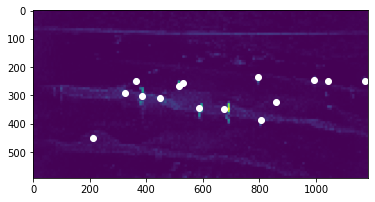

In [12]:
# n, img, heatimg = predict(df.iloc[0], patch_size = patch_size)

print(n)
plt.imshow(heatimg)
plt.scatter(blobs[:, 1], blobs[:, 0], c='white')
plt.show()

In [25]:
preds = []
for i in range(len(df)):
    print(i, end = ' ')
    n,_,_,_ = predict(df.iloc[i], patch_size = patch_size)
    preds.append(n)
    
print(n)
df['surfer count'] = preds
df
#     print(row['time'])

0 

/home/lathomas5/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/lathomas5/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 14


,filename,time,surfer count
0,./data/images/2021-07-12 07:35:03-07:00.png,2021-07-12 07:35:03-07:00,15
1,./data/images/2021-07-12 07:36:03-07:00.png,2021-07-12 07:36:03-07:00,17
2,./data/images/2021-07-12 07:37:03-07:00.png,2021-07-12 07:37:03-07:00,15
3,./data/images/2021-07-12 07:38:03-07:00.png,2021-07-12 07:38:03-07:00,12
4,./data/images/2021-07-12 07:39:03-07:00.png,2021-07-12 07:39:03-07:00,15
...,...,...,...
193,./data/images/2021-07-12 07:00:57-07:00.png,2021-07-12 07:00:57-07:00,14
194,./data/images/2021-07-12 07:01:57-07:00.png,2021-07-12 07:01:57-07:00,17
195,./data/images/2021-07-12 07:02:57-07:00.png,2021-07-12 07:02:57-07:00,13
196,./data/images/2021-07-12 07:03:57-07:00.png,2021-07-12 07:03:57-07:00,12


In [28]:
sdf = df.sort_values('time')

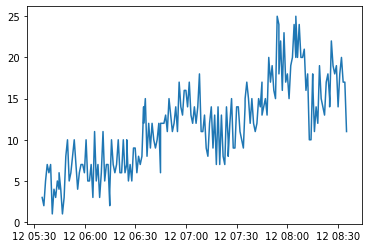

In [29]:
fig, ax = plt.subplots(1,1)
ax.plot(sdf.time, sdf['surfer count'])